# Introduction
 - Raman has been used to classify mineral types and has growing use in biomedical applications
 - Traditional methods rely on baseline normalization and PCA to extract features
 - Recent work has shown that CNN's can outperform manual baseline normalization techniques
 - This project is to train a CNN to process raw Raman spectra from the RUFF database and apply transfer learning to process raw raman from other applications

In [198]:
%load_ext autoreload
%autoreload 1
%matplotlib inline

from lib.utils import RamanSample
import numpy as np
import pandas as pd
import csv
import pickle
import matplotlib.pyplot as plt
import time
import glob
import os
import shutil

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Formatting Data Files
In order to use an `ImageDataGenerator` and flow it from a directory, we need to setup our data so that each subdirectory of the main directory represents a label.

In [213]:
raw_files = glob.glob("data/*/*.txt")

for fname in raw_files:
    #fname = raw_files[np.random.randint(len(raw_files))]
    basename, ext = os.path.splitext(os.path.basename(fname))
    compound, rlabel, ir_type, wv, n, orientation, data_status, rid = basename.split("__")

    #print("{} with wavelength {} - {}".format(compound, wv, data))
    path = os.path.join("data", "{}/{}/{}".format(data_status, orientation, compound))
    os.makedirs(path, exist_ok=True)

    shutil.copy(fname, path)

data/unrated_unoriented/Zykaite__R070477__Raman__785__0__unoriented__Raman_Data_RAW__22174.txt of 15757
(2328, 2)
[[ 145.5055        0.64089744]
 [ 145.9876        0.66666774]
 [ 146.4697        0.68974313]
 [ 146.9518        0.70939088]
 [ 147.434         0.72735572]]


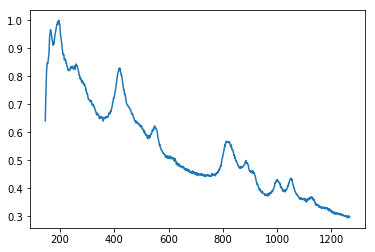

In [214]:
data = np.genfromtxt(fname,
                    dtype=None,
                    comments="##",
                    delimiter=",",
                    names=["wavenumber", "intensity"]
                 )
print("{} of {}".format(fname, len(raw_files)))
m = max(data["intensity"])
data["intensity"] = data["intensity"] / m
plt.plot(data["wavenumber"], data["intensity"])
dx = np.matrix([data["wavenumber"], data["intensity"]]).transpose()
print(dx.shape)
print(dx[:5,:])

(7832, 701)


In [18]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

path = "data/processed/spectra_with_label2.csv"
#path = "data/processed/sample.csv"

my_data = pd.read_csv(path).as_matrix()
print(my_data.shape)
y, X = my_data[:, 0], my_data[:, 1:]


label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_labels = len(set(y_encoded))
one_hot_encoder = OneHotEncoder(sparse=False)
y_train = one_hot_encoder.fit_transform(y_encoded.reshape(-1,1))
X_train = X.reshape((X.shape[0], X.shape[1], 1, 1))


(7832, 700, 1, 1)


In [9]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, LeakyReLU, Dropout, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


## ImageDataGenerator
We want to produce slightly altered spectra to augment our training set.  
### TODO:
- Refactor preprocessing so that labels are inferred from subdirectories and images are produced automatically
- Refactor "channels" so that each channel is represented by a laser wavelength, likely (532nm, 780nm, 830nm)

In [13]:
dataGen = ImageDataGenerator(
    rotation_range=15, 
    width_shift_range=0.15, 
    height_shift_range=0.15,
    zoom_range=0.15, 
    data_format="channels_last")

dataGen.fit(X_train)

Monticellite
Monticellite
Monticellite
Monticellite
Monticellite


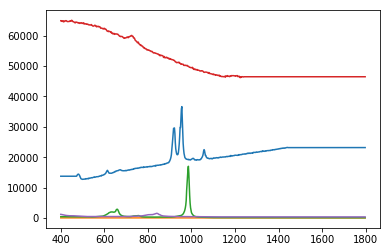

In [46]:
for x, y in dataGen.flow(X_train,y_train, batch_size=5):
    for batch in x:
        print(label_encoder.inverse_transform(np.argmax(y)))
        plt.plot(np.array(range(400,1800,2)),batch[:,0,0])
    break


In [15]:
model = Sequential()
model.add(Conv2D(filters=128, kernel_size=20, padding='same', activation='relu', input_shape=(X_train.shape[1:])))
model.add(MaxPooling1D(pool_size=2, padding='valid'))
#model.add(LeakyReLU(alpha=.2))
model.add(Conv1D(filters=64, kernel_size=10, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, padding='valid'))
#model.add(LeakyReLU(alpha=.2))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
#model.add(LeakyReLU(alpha=.2))
model.add(MaxPooling1D(pool_size=2, padding='valid'))
#model.add(GlobalAveragePooling1D())
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(num_labels, activation="softmax"))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 700, 128)          2688      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 350, 128)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 350, 64)           81984     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 175, 64)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 175, 64)           16448     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 87, 64)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5568)              0         
__________

In [16]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
checkpoint = ModelCheckpoint("models/raman.s", save_best_only=True)

In [17]:
epochs=5
batch_size=50

model.fit(X_train[:1000, :], y_train[:1000], epochs=epochs, batch_size=batch_size, 
          verbose=1, validation_split=0.1, shuffle=True,
          callbacks=[checkpoint]
         )

Train on 900 samples, validate on 100 samples
Epoch 1/5
900/900 [==============================] - 10s 11ms/step - loss: 13.4578 - acc: 0.0367 - val_loss: 13.9785 - val_acc: 0.0200
Epoch 2/5
900/900 [==============================] - 10s 11ms/step - loss: 10.7508 - acc: 0.1122 - val_loss: 9.1913 - val_acc: 0.0600
Epoch 3/5
900/900 [==============================] - 10s 11ms/step - loss: 8.6598 - acc: 0.1589 - val_loss: 12.9936 - val_acc: 0.0800
Epoch 4/5
900/900 [==============================] - 10s 11ms/step - loss: 8.0969 - acc: 0.1911 - val_loss: 9.0064 - val_acc: 0.0900
Epoch 5/5
900/900 [==============================] - 11s 12ms/step - loss: 8.3604 - acc: 0.1789 - val_loss: 8.3976 - val_acc: 0.0700
